In [77]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [78]:
class FullyConnectedLayer:
    
    def __init__ (self, name, n_in, n_out, learning_rate):
        '''
        name: Name of this later. Choose any string that uniquely identifies this layer
        n_in: number of inputs
        n_out: number of outputs
        learning_rate: learning rate
        '''
        self.weights = np.random.uniform(low=-0.5, high=0.5, size=(n_in,n_out))
        self.bias = np.random.uniform(low=-0.5, high=0.5, size=(1,n_out))
        self.name = name
        
    def print_self (self):
        print "Layer: " + self.name
        print "Weights"
        print self.weights
        print "Bias"
        print self.bias
        
    def get_parameters(self):
        return self.weights, self.bias
    
    def get_layer_type(self):
        return "fully_connected"
    
    def forward_pass(self, input_vector):
        self.input_vector = input_vector
        return np.matmul(input_vector, self.weights) + self.bias
    
    def _compute_gradient_weights(self, error_upper_layer):
        grad_weights = np.zeros_like(self.weights)
        # For every i/o pair
        for i, o in zip(self.input_vector, error_upper_layer):
            grad_weights = grad_weights + np.outer(i, o)
        return grad_weights
    
    def _compute_error_lower_layer(self, error_upper_layer):
        return np.matmul(error_upper_layer, self.weights.transpose())
    
    def _compute_error_bias(self, error_upper_layer):
        return np.sum(error_upper_layer, 0)
    
    def backward_pass(self, error_upper_layer):
        # Compute error for upper layer
        error_lower_layer = self._compute_error_lower_layer(error_upper_layer) 
        # Compute gradients on weights
        grad_weights = self._compute_gradient_weights(error_upper_layer)
        # Compute gradients on bias
        grad_bias = self._compute_error_bias(error_upper_layer)
        # Adjust weights and bias just a little bit in direction to opposite to the gradient to minimize loss
        self.weights = self.weights - learning_rate * grad_weights
        self.bias = self.bias - learning_rate * grad_bias
        # return error
        return error_lower_layer

In [79]:
class SigmoidLayer:
    
    def __init__(self, name):
        self.name = name
        
    def forward_pass(self, input_data):
        self.sigmoid_values  = 1 / (1 + np.exp(-input_data))
        return self.sigmoid_values
    
    def backward_pass(self, error_upper_layer):
        return np.multiply(self.sigmoid_values, 1-self.sigmoid_values)
    
    def print_self (self):
        print "Layer: " + self.name
        print "No learned parameters in this layer"
        
    def get_parameters(self):
        return None
    
    def get_layer_type(self):
        return "sigmoid"

In [80]:
class ReLU:
    
    def __init__(self, name):
        self.name = name
        
    def forward_pass(self, input_data):
        self.condition =  input_data > 0
        return np.where(self.condition, input_data, 0)
    
    def backward_pass(self, error_upper_layer):
        return np.where(self.condition, error_upper_layer, 0)
    
    def print_self (self):
        print "Layer: " + self.name
        print "No learned parameters in this layer"
        
    def get_parameters(self):
        return None
    
    def get_layer_type(self):
        return "relu"

In [81]:
def softmax(row):
    exprow = np.exp(row)
    exprow = exprow / np.sum(exprow)
    return exprow

class SoftmaxLossLayer:
    
    def __init__(self, name):
        self.name = name
    
    def forward_pass(self, input_vector):
        # Apply softmax to each input vector
        self.prob = np.apply_along_axis( softmax, 1, input_vector )
        return self.prob
    
    def get_parameters(self):
        return None

    def get_layer_type(self):
        return "softmax_loss"
    
    def print_self (self):
        print "Layer: " + self.name
        print "No learned parameters in this layer"
        
    def backward_pass(self, expected_output):
        return self.prob - expected_output

In [82]:
class NeuralNetwork:
    
    def __init__(self):
        self.layers = []
    
    def add_layer(self, layer):
        self.layers.append(layer)
        
    def print_self (self):
        for layer in self.layers:
            layer.print_self()
            
    def get_layers (self):
        return self.layers
        
    def forward_pass(self, input_vector):
        data = input_vector
        for layer in self.layers:
            data = layer.forward_pass(data)
        return data
            
    def backward_pass(self, expected_output):
        data = expected_output
        for layer in reversed(self.layers):
            data = layer.backward_pass(data)
        return data
            
    def train(self, num_iterations, input_vector, expected_output):
        for i in range(num_iterations):
            #print "Iteration " + str(i) + " of " + str(num_iterations)
            self.forward_pass(input_vector)
            self.backward_pass(expected_output)

In [83]:
# Define constats
learning_rate = 0.0001
n_in1 = 2
n_out1 = 10
n_in2 = 10
n_out2 = 3
n_in3 = 3
n_out3 = 2

# Construct a NN
nn = NeuralNetwork()
nn.add_layer(FullyConnectedLayer("layer 1", n_in1, n_out1, learning_rate))
nn.add_layer(ReLU("relu 1"))
nn.add_layer(FullyConnectedLayer("layer 2", n_in2, n_out2, learning_rate))
nn.add_layer(ReLU("relu 2"))
nn.add_layer(FullyConnectedLayer("layer 3", n_in3, n_out3, learning_rate))
nn.add_layer(SoftmaxLossLayer("softmax_loss"))

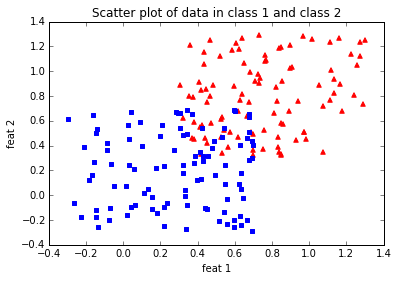

In [84]:
# define i/o
def generate_random_input (num_points_per_class):
    # randomly select class 1
    class_1_data = np.random.rand(num_points_per_class,2)
    class_1_data = class_1_data + 0.3
    class_1_label = np.tile([1, 0],(num_points_per_class,1))
    # randomly select class 2
    class_2_data = np.random.rand(num_points_per_class,2)
    class_2_data = class_2_data - 0.3
    class_2_label = np.tile([0, 1],(num_points_per_class,1))
    # concatenate data and label
    data = np.concatenate((class_1_data, class_2_data), axis=0)
    label = np.concatenate((class_1_label, class_2_label), axis=0)
    
    return data, label

def plot_data (data, label):
    for d, l in zip(data, label):
        if l[0] > 0.5:
            plt.scatter(d[0], d[1], color='r', marker='^')
        else:
            plt.scatter(d[0], d[1], color='b', marker='s')
    plt.title('Scatter plot of data in class 1 and class 2')
    plt.xlabel('feat 1')
    plt.ylabel('feat 2')
    
data, label =  generate_random_input(100)
plot_data (data, label)

In [85]:
num_iterations = 2000

nn.train(num_iterations, data, label)
nn.print_self()

Layer: layer 1
Weights
[[ -2.34705043e-01   4.77069921e-01  -1.27077248e-01  -4.34242538e-01
    1.01716543e-01   3.44617958e-01   6.01265787e-01   6.27187101e-01
    7.90135176e-03  -5.11983781e-01]
 [  2.76218287e-01   2.76201026e-01  -1.60626695e-01   3.08562955e-02
   -4.72857084e-01   4.72667101e-01   5.31944506e-01   6.14593055e-01
   -2.93589787e-04  -5.60130330e-01]]
Bias
[[-0.45185078  0.08893102 -0.36934177  0.76829623  0.70454169 -0.10278033
  -0.16082079 -0.17367306  0.44129805  0.81303047]]
Layer: relu 1
No learned parameters in this layer
Layer: layer 2
Weights
[[ 0.34375557 -0.40119457 -0.27851601]
 [-0.35306916 -0.46432617  0.12694418]
 [ 0.11475597 -0.34501375  0.38588271]
 [-0.43780683  0.5012733   0.52362346]
 [-0.42651227  0.73979238  0.28019254]
 [-0.47056644 -0.4474559  -0.5172471 ]
 [ 0.28415343 -0.50448828 -0.634422  ]
 [-0.28608092 -0.82227687 -0.47861507]
 [ 0.22524819 -0.24469267  0.48227218]
 [ 0.22474169  0.76745872  0.61218449]]
Bias
[[-0.06576901  0.90673

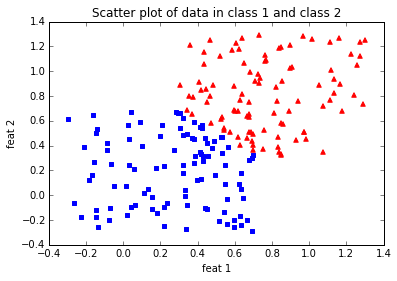

In [86]:
scores = nn.forward_pass(data)
plot_data (data, scores)